<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel), and Mikhail Korshchikov (@MS4). [mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2021

# <center>Assignment #3. Task </center> <a class="tocSkip">
## <center>Decision trees for classification and regression </center><a class="tocSkip">

In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.

### Your task is to:
 1. write code and perform computations in the cells below;
 2. choose answers in the [webform](https://docs.google.com/forms/d/1ZUYREiTJjg8IiZAIIMdWRODtPe1qfC0UBYq_i2WFe1c/). 
 

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_eng__, pinned thread __#a3_bonus__. If you are sure that something is not 100% correct, please leave your feedback via the mentioned webform ↑*

-----

In [1]:
import numpy as np
import pandas as pd

# if seaborn is not yet installed, run `pip install seaborn` in terminal
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    'axes.spines.top': False,       # Turn off top spine
    'axes.spines.right': False
})

## 1. Decision trees for regression: a toy example

Let's consider the following one-dimensional regression problem. We need to build a function $\large a(x)$ to approximate the dependency $\large y = f(x)$ using the mean-squared error criterion: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

In [2]:
X = np.linspace(-2, 2, 8)
y = X ** 3  # original dependecy

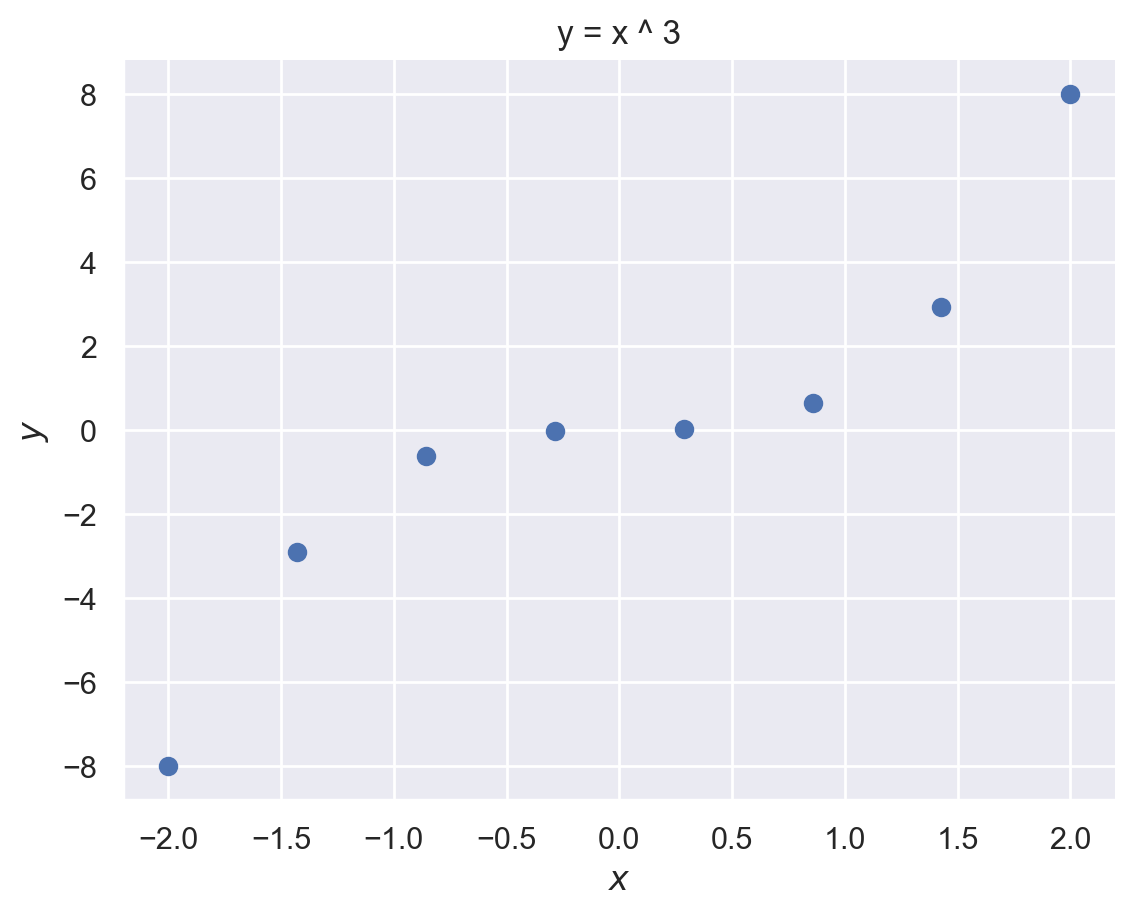

In [3]:
plt.scatter(X, y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("y = x ^ 3")

plt.show()

Let's make several steps to build a decision tree. In the case of a **regression** task, at prediction time, the leaf returns the average value for all observations in this leaf.

Let's start with a tree of depth 0, i.e. all observations placed in a single leaf. 

<br>You'll need to build a tree with only one node (also called **root**) that contains all train observations (instances). 
<br>How will predictions of this tree look like for $x \in [-2, 2]$? <br> Create an appropriate plot using a pen, paper and Python if needed (but no `sklearn` is needed yet).

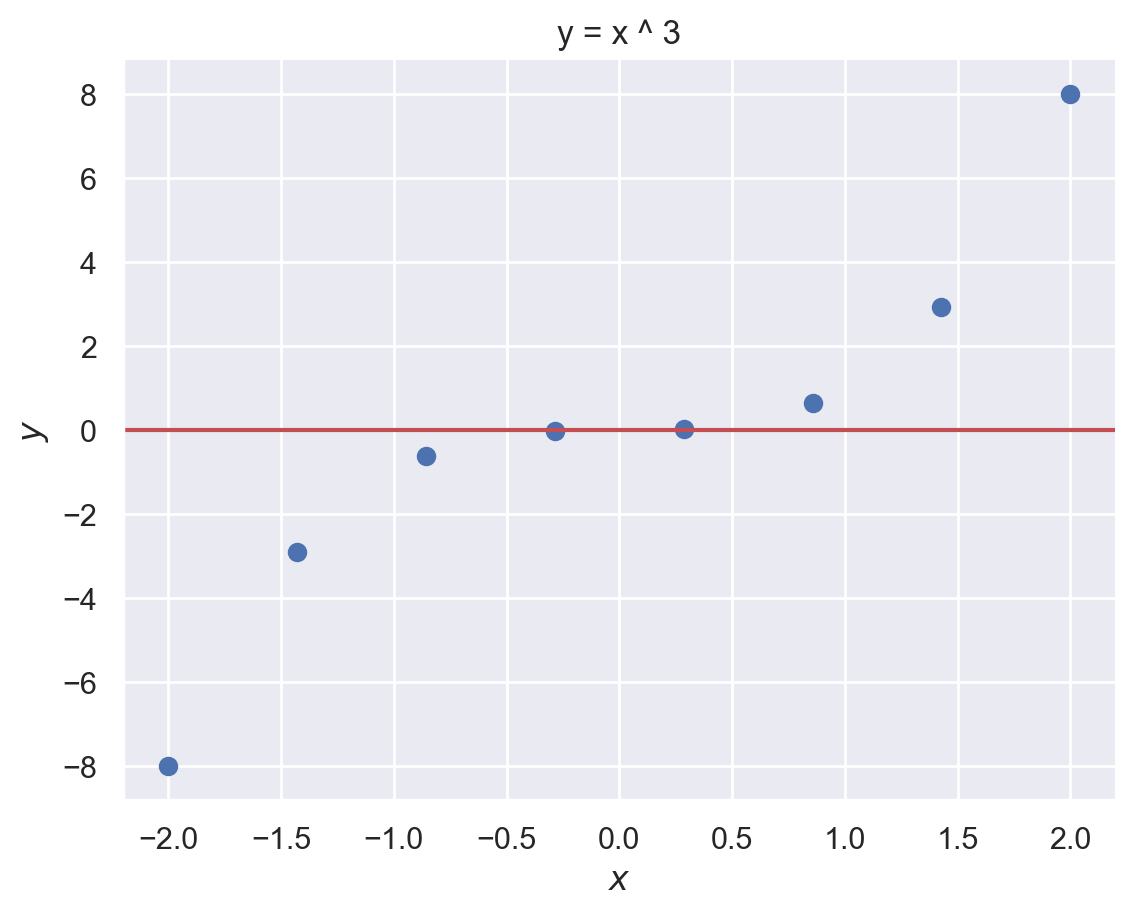

In [4]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)
plt.scatter(X, y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("y = x ^ 3")

plt.axhline(y=y.mean(), color='r', linestyle='-')

plt.show()

**Making first splits.**
<br>Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. To clarify, for all instances with $x \geqslant 0$ the tree will return some value, for all instances with $x < 0$ it will return another value. Let's create a similar plot for predictions of this tree.

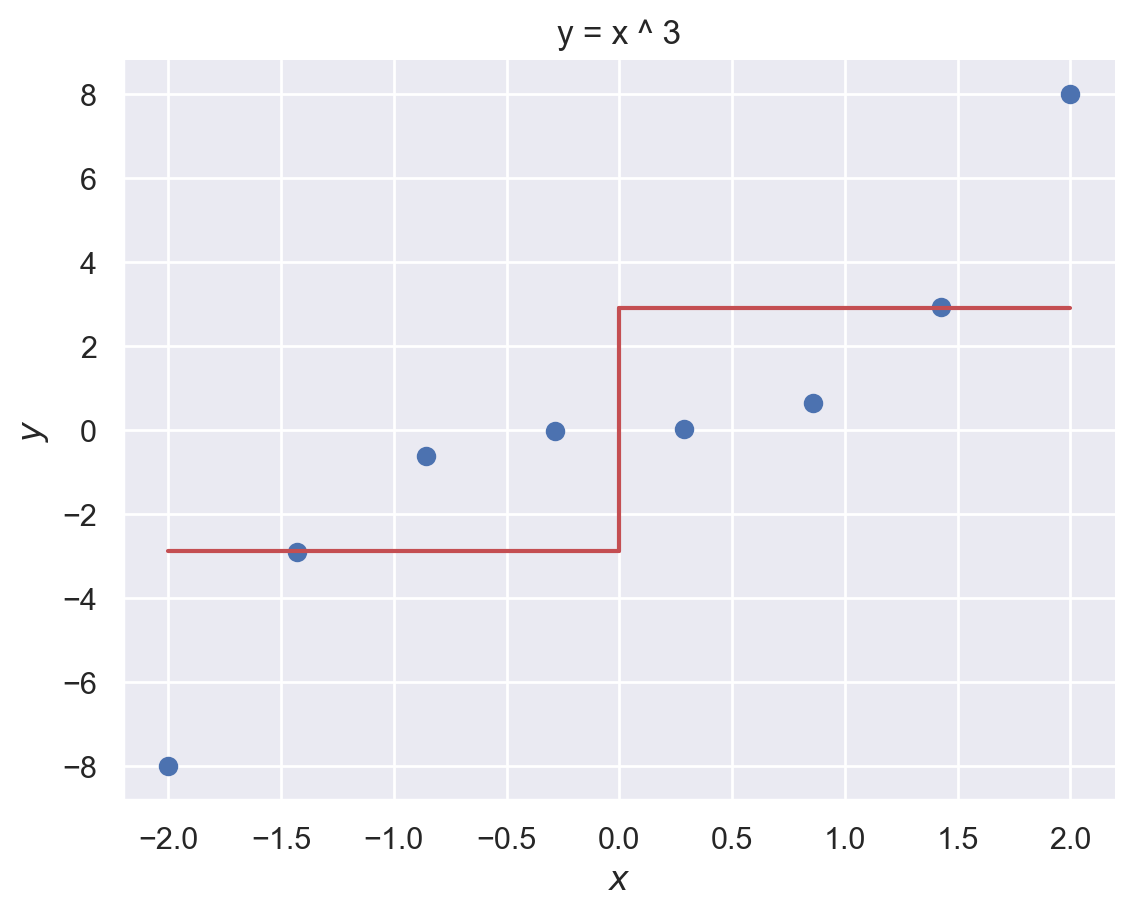

In [5]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)
plt.scatter(X, y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("y = x ^ 3")

y_coord_left = y[np.array(X) < 0].mean()
y_coord_right = y[np.array(X) >= 0].mean()

plt.plot((X[0], 0), (y_coord_left, y_coord_left), color='r', linestyle='-')
plt.plot((0, X[-1]), (y_coord_right, y_coord_right), color='r', linestyle='-')
plt.plot((0, 0), (y_coord_left, y_coord_right), color='r', linestyle='-')

plt.show()

In the decision tree algorithm, the feature and the threshold for splitting are chosen according to some criterion. The commonly used criterion for regression is based on variance:

$$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$

where $\large X$ and $\large y$ are a feature matrix and a target vector (correspondingly) for training instances in a current node, $\large X_l, y_l$ and $\large X_r, y_r$ are splits of samples $\large X, y$ into two parts w.r.t. $\large [x_j < t]$ (by $\large j$-th feature and threshold $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (or, the same, $\large |y|$, $\large |y_l|$, $\large |y_r|$) are sizes of appropriate samples, and $\large D(X, y)$ is variance of answers $\large y$ for all instances in $\large X$:

$$\large D(X, y) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$

Here $\large y_i = y(x_i)$ is the answer for the $\large x_i$ instance. Feature index $\large j$ and threshold $\large t$ are chosen to maximize the value of criterion  $\large Q(X, y, j, t)$ for each split.

In our 1D case,  there's only one feature so $\large Q$ depends only on threshold $\large t$ and training data $\large X$ and $\large y$. Let's designate it $\large Q_{1d}(X, y, t)$ meaning that the criterion no longer depends on feature index $\large j$, i.e. in 1D case $\large j = 1$.

In [6]:
def regression_var_criterion(X, y, t):
    # You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)
    X_l, X_r = X[X < t], X[X >= t]
    y_l, y_r = y[X < t], y[X >= t]

    return (
        np.var(y)
        - X_l.shape[0] / X.shape[0] * np.var(y_l)
        - X_r.shape[0] / X.shape[0] * np.var(y_r)
    )

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $\large [-1.9, 1.9]$.

Text(0, 0.5, 'Regression variance criterion')

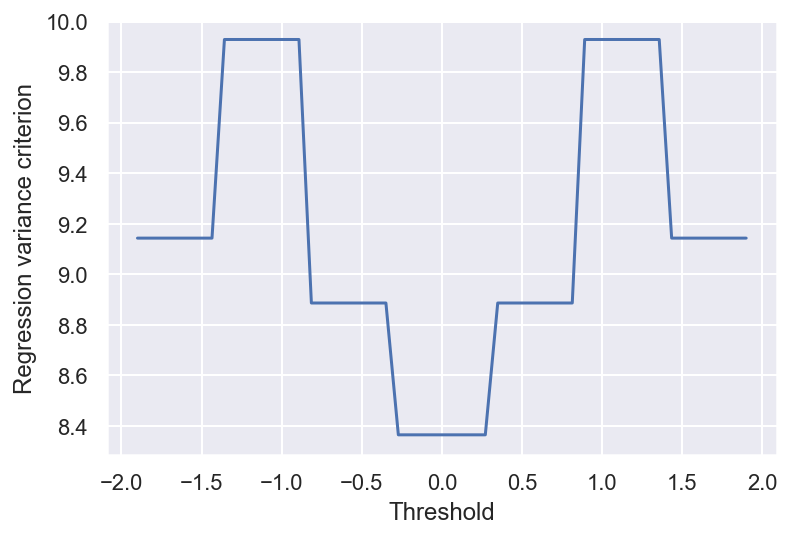

In [7]:
thresholds = np.linspace(-1.9, 1.9)
Q_t = [regression_var_criterion(X, y, t) for t in thresholds]
plt.plot(thresholds, Q_t)
plt.xlabel("Threshold")
plt.ylabel("Regression variance criterion")
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

**<font color='red'>Question 1.</font> What is the worst threshold value (to perform a split) according to the variance criterion?**
- -1.9
- -1.3
- 0 **[+]**
- 1.3
- 1.9 

Then let's make splitting in each of the leaves nodes. 
<br> Take your tree with first threshold [$x<0$].
<br> Now add a split in the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. 
<br>It gives us a tree of depth 2 with 7 nodes and 4 leaves. Create a plot of this tree predictions for $x \in [-2, 2]$.

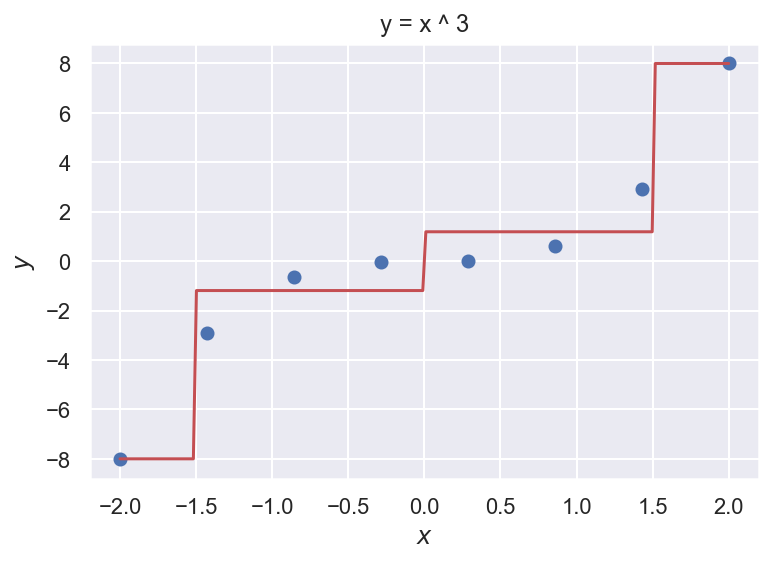

In [8]:
def predict(X, y, x_val):
    if x_val < - 1.5:
        return y[X < -1.5].mean()
    elif x_val >= -1.5 and x_val < 0:
        return y[(X >= -1.5) & (X < 0)].mean()
    elif x_val >= 0 and x_val < 1.5:
        return y[(X >= 0) & (X < 1.5)].mean()
    else:
        return y[X >= 1.5].mean()

x_space = np.linspace(-2, 2, 200)
predictions = [predict(X, y, x_val) for x_val in x_space]
plt.scatter(X, y)
plt.plot(x_space, predictions, c='r')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("y = x ^ 3")

plt.show()

# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

**<font color='red'>Question 2.</font> Tree predictions is a piecewise-constant function, right? How many "pieces" (horizontal segments in the plot that you've just built) are there in the interval [-2, 2]?**
- 2
- 4 **[+]**
- 6
- 8

4 because we have 4 leaves and for every leaf we calculate the mean for $y$.

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. The dataset can be downloaded from the course repo from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking on `Download` and then selecting `Save As` option. If you work with Git, then the dataset is already there in `data/mlbootcamp5_train.csv`.

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [9]:
df = pd.read_csv(
    "../data/assignment3/mlbootcamp5_train.csv", index_col="id", sep=";"
)

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Transform the features: 
- create "age in years" dividing age by 365.25 and taking floor ($\lfloor{x}\rfloor$ is the largest integer that is less than or equal to $x$) 
- create 3 binary features based on `cholesterol`.
- create 3 binary features based on `gluc`.
<br> Binary features equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummies`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [11]:
cholesterol_dummies = pd.get_dummies(df["cholesterol"], prefix='cholesterol')
gluc_dummies = pd.get_dummies(df["gluc"], prefix='gluc')

df = pd.concat([df, gluc_dummies, cholesterol_dummies], axis=1)
df["age_in_years"] = df["age"].apply(lambda age: np.floor(age / 365.25))

df.drop(["age", "cholesterol", "gluc"], axis=1, inplace=True)
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop("cardio", axis=1), df["cardio"], test_size=0.3, random_state=17)
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

Train a decision tree on the dataset `(X_train, y_train)` with **max depth equal to 3** and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz` and Graphviz. Here we need to mention that `sklearn` doesn't draw decision trees on its own, but is able to output a tree in the `.dot` format that can be used by Graphviz for visualization. 

How to plot a decision tree, alternatives:
 1. Install Graphviz and pydotplus yourself (see below)
 2. Use our docker image with all needed packages already installed
 3. Easy way: execute `print(dot_data.getvalue())` with `dot_data` defined below (this can be done without pydotplus and Graphviz), go to http://www.webgraphviz.com, paste the graph code string (digraph Tree {...) and generate a nice picture

Take a look how trees are visualized in the [3rd part](https://mlcourse.ai/articles/topic3-dt-knn/) of course materials.

There are may be some troubles with graphviz for Windows users.
The error is 'GraphViz's executables not found'.
<br>To fix that – install Graphviz from [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html).
<br>Then add graphviz path to your system PATH variable. You can do this manually, but don't forget to restart kernel.
<br>Or just run this code:

In [13]:
# import os
# path_to_graphviz = '' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example)
# os.environ["PATH"] += os.pathsep + path_to_graphviz

In [14]:
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [15]:
# !pip install pydotplus

In [16]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [17]:
tree_graph_to_png(
    tree=dt,
    feature_names=dt.feature_names_in_,
    png_file_to_save="decision_tree.png",
)

![Decision Tree](decision_tree.png)

**<font color='red'>Question 3.</font> Which 3 features are used to make predictions in the created decision tree?**
- age, ap_lo, chol=1
- age, ap_hi, chol=3 **[+]**
- smoke, age, gender
- alco, weight, gluc=3

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [18]:
pred = dt.predict(X_valid)

acc = accuracy_score(y_valid, pred)
print(f"Accuracy on validation set is equal to {acc.round(2)}")
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

Accuracy on validation set is equal to 0.72


Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [19]:
%%time
dt_cv = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid={"max_depth":range(2, 11)}, cv=5, scoring='accuracy')
dt_cv.fit(X_train, y_train)
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

CPU times: total: 1.98 s
Wall time: 1.99 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)}, scoring='accuracy')

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

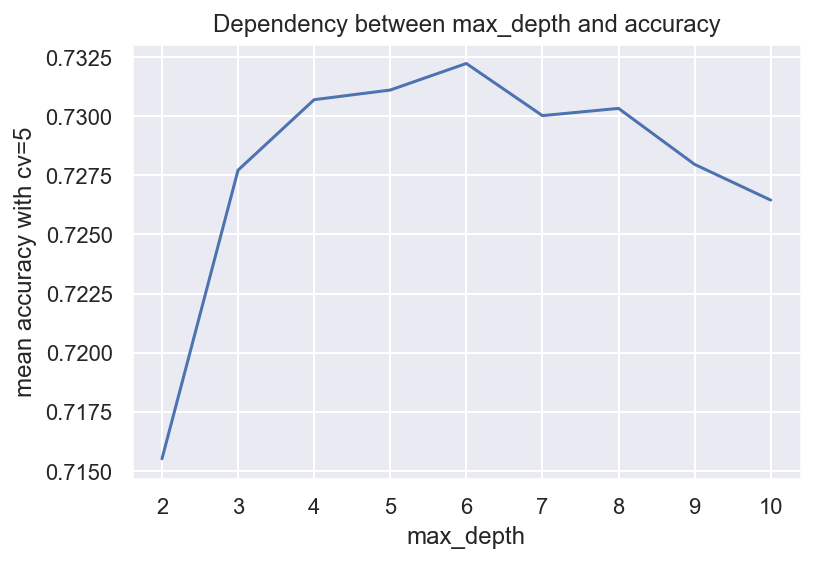

In [20]:
plt.plot(range(2, 11), dt_cv.cv_results_["mean_test_score"])
plt.xlabel("max_depth")
plt.ylabel("mean accuracy with cv=5")
plt.title("Dependency between max_depth and accuracy")
plt.show()
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. This can be done with the trained instance of the class `GridSearchCV`.

In [21]:
print(f"The best max_depth is {dt_cv.best_params_['max_depth']}")
pred_cv = dt_cv.predict(X_valid)
acc_cv = accuracy_score(y_valid, pred_cv)
print(f"Accuracy on validation set with fine-tuned model and cross-validation is equal to {acc_cv.round(2)}")
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

The best max_depth is 6
Accuracy on validation set with fine-tuned model and cross-validation is equal to 0.73


Сalculate the effect of `GridSearchCV`: check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning max_depth with GridSearchCV respectively.

In [22]:
print(f"The effect of GridSearchCV is {((acc_cv - acc) / acc * 100).round(2)}%")
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

The effect of GridSearchCV is 0.6%


**<font color='red'>Question 4.</font> Choose all correct statements:**
- There exists a local maximum of accuracy on the built validation curve **[+]**
- `GridSearchCV` increased holdout accuracy by **more** than 1% 
- There is **no** local maximum of accuracy on the built validation curve
- `GridSearchCV` increased holdout accuracy by **less** than 1% **[+]**

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='../static/SCORE2007-eng.png' width=70%>

Let's create new features according to this picture:
- $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. 

<br>Add a ``smoke`` feature.
<br>Build the ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally, the decision tree is built using these 12 binary features (excluding all original features that we had before this feature engineering part).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be left with their default values.

**<font color='red'>Question 5.</font> Which binary feature is the most important for heart disease detection (i.e., it is placed in the root of the tree)?**
- Systolic blood pressure from 160 to 180 (mmHg)
- Cholesterol level == 3
- Systolic blood pressure from 140 to 160 (mmHg) **[+]**
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

In [23]:
new_df = pd.DataFrame()
new_df['age_in_years_40_49'] = df['age_in_years'].isin([40, 49]).astype('int')
new_df['age_in_years_50_54'] = df['age_in_years'].isin([50, 54]).astype('int')
new_df['age_in_years_55_59'] = df['age_in_years'].isin([55, 59]).astype('int')
new_df['age_in_years_60_64'] = df['age_in_years'].isin([60, 64]).astype('int')

new_df['api_hi_120_139'] = df['ap_hi'].isin([120,139]).astype('int')
new_df['api_hi_140_159'] = df['ap_hi'].isin([140,159]).astype('int')
new_df['api_hi_160_179'] = df['ap_hi'].isin([160,179]).astype('int')

new_df['smoke'] = df['smoke']

new_df = pd.concat([new_df, cholesterol_dummies], axis=1)
new_df['male'] = df['gender'].map({1:0, 2:1})

new_df.head(3)
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

,age_in_years_40_49,age_in_years_50_54,age_in_years_55_59,age_in_years_60_64,api_hi_120_139,api_hi_140_159,api_hi_160_179,smoke,cholesterol_1,cholesterol_2,cholesterol_3,male
id,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,1,0,0,1
1,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df, df["cardio"], test_size=0.3, random_state=17)

In [25]:
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=17)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [26]:
tree_graph_to_png(
    tree=dt_clf,
    feature_names=dt_clf.feature_names_in_,
    png_file_to_save="decision_tree_2.png",
)

![Decision Tree](decision_tree_2.png)